# Demo of reading, decompressing, and storing JMA landslide risk figures

___
__Important:__ In this repository, we provide some scripts to handle the numerical landslide risk assessment figures prepared in 10-minute intervals by the Japan Meteorological Agency (JMA). This data is  *not freely available data*, but must rather be purchased from the Japan Meteorological Business Support Center (JMBSC), which operates under the oversight of the JMA. Here are a couple relevant links:

- Up to date visualized plot of landslide risk figures:<br> https://www.jma.go.jp/jp/doshamesh/

- JMBSC page for landslide risk data set:<br> http://www.jmbsc.or.jp/jp/online/file/f-online60210.html

<img src="img/dosha_example.jpeg" width="300">

This data is only provided in a standard binary format used frequently in meteorology, called *FM92 GRIB edition 2*. The software in this repository assumes that the user has already acquired such data via the appropriate channels.
___

Let's give a typical example of the folder structure one will be dealing with in practice. Here we have obtained data for the first ten-minute interval taken from the first ten hours (00:00-00:10, 01:00-01:10, etc.) of two consecutive days (in this example, we use July 1st and 2nd, 2013).

In [2]:
! ls -R demo_data/

demo_data/:
20130701  20130702

demo_data/20130701:
Z__C_RJTD_20130701000000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701010000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701020000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701030000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701040000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701050000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701060000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701070000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701080000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701090000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130701100000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin

demo_data/20130702:
Z__C_RJTD_20130702000000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130702010000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130702020000_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
Z__C_RJTD_20130702030000_MET_INF_Jdosha_Ggis5

While we make no assumptions about the naming of directories, we shall pass them to a script as follows:

```
$ ./prep_dosha.sh DIR1 DIR2 DIR3 ...
```

where the assumption that the contents of `DIR1` come *chronologically* before the contents of `DIR2`, which come chronologically before the contents of `DIR3`, and so forth.

The other important assumption here is regarding the format of the file names. The general format assumed here is

```
Z__C_RJTD_YYYYMMDDHHNN00_MET_INF_Jdosha_Ggis5km_ANAL_grib2.bin
```

where `YYYY`, `MM`, `DD`, `HH`, `NN` are respectively year, month, day, hour, and minute. Since the data is prepared for 10-minute intervals, the `NN` will take values in `{00,10,20,30,40,50}`.

Let's import the modules required for this routine.

In [3]:
import tables
import numpy as np
import os
from read_dosha import DoshaMesh

There is just one configuration file (`config_dosha.py`) that can be modified as desired:

In [4]:
! cat config_dosha.py

'''
Configuration file for the script generating hierarchical data
objects based on JMA landslide risk data set.

Reference on the technical elements:
 JMA Technical Report 374 (Japanese)
 http://www.data.jma.go.jp/add/suishin/jyouhou/pdf/374.pdf
'''

# Author: Matthew J. Holland, Osaka University


# Main user-defined constants.
FILE_NAME = "demo_datafile.h5"
FILE_TITLE = "Demonstration of full landslide risk data object."
DATA_TITLE = "Array storing numerical risk levels."
GRIDINFO_TITLE = "Grid coordinate information."
DATETIME_TITLE = "Date-time entries, with corresponding risk level entries."
VERBOSE = False

# Key facts to be hard-coded; likely no need to modify.
DATAFILE_HEADER = "Z__C_RJTD_"
NUMLAT = 560 # height of grid
NUMLON = 512 # width of grid
NUMCELLS= NUMLON*NUMLAT # multiply the dimensions of the lattice.
DEG_FIRSTLAT = 47.975
DEG_FIRSTLON = 118.03125
DEG_LASTLAT = 20.025
DEG_LASTLON = 149.96875
DEG_LATSIZE = 3.0/60
DEG_LONSIZE = 3.75/60
INFO_LIST = [DEG_FIRSTLAT, DEG_

All that remains is to feed the directories of interest to a script and let it run.

In [5]:
! ./prep_dosha.sh demo_data/*

In [6]:
! ls

config_dosha.py   demo.ipynb	 prep_dosha.py	read_dosha.py
demo_data	  dosha_test.h5  prep_dosha.sh	README.md
demo_datafile.h5  img		 __pycache__


We see that a new file, `demo_datafile.h5`, has been created. All that remains is to look at the innards of this hierarchical data file to ensure that it is what we expect.
___

Assuming we have run the above code and generated a sample `.h5` file, let's try reading its contents and visualizing the data of interest.

In [7]:
import tables
import numpy as np
import os
from read_dosha import DoshaMesh, datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [8]:
myh5 = tables.open_file("demo_datafile.h5", mode="r")
print(myh5)

demo_datafile.h5 (File) 'Demonstration of full landslide risk data object.'
Last modif.: 'Mon May 21 16:30:58 2018'
Object Tree: 
/ (RootGroup) 'Demonstration of full landslide risk data object.'
/dateTime (EArray(22, 5)) b'Date-time entries, with corresponding risk level entries.'
/gridInfo (EArray(1, 6)) b'Grid coordinate information.'
/riskLevels (EArray(22, 560, 512)) b'Array storing numerical risk levels.'



Well, everything looks about as we would expect. The arrays stored in `dateTime` and `riskLevels` both have 24 rows, as expected (24 = 2 days x 2 hours x 6 ten-minute intervals). A check for this helps prevent any unforeseen inconsistencies in our records.

In [9]:
num_entries_dt = myh5.root.dateTime.shape[0]
num_entries_X = myh5.root.riskLevels.shape[0]

print("Number of date-time entries:", num_entries_dt)
print("Number of data entries:", num_entries_X)

if num_entries_dt != num_entries_X:
    print("Error: the number of date-time and "\
          "dosha level entries do not match")

Number of date-time entries: 22
Number of data entries: 22


Let's visualize the lattice of risk levels for the short period covered by the small data set examined in this demo:

In [10]:
tocheck = np.arange(0, num_entries_dt, 2) # once every two hours

gridinfo = myh5.root.gridInfo[0,:]
deg_lat = np.arange(gridinfo[0], gridinfo[1]-0.0001, -gridinfo[2])
deg_lon = np.arange(gridinfo[3], gridinfo[4]+0.0001, gridinfo[5])

Lat, Lon = np.meshgrid(deg_lat, deg_lon) # all the (lat,lon) coordinate values

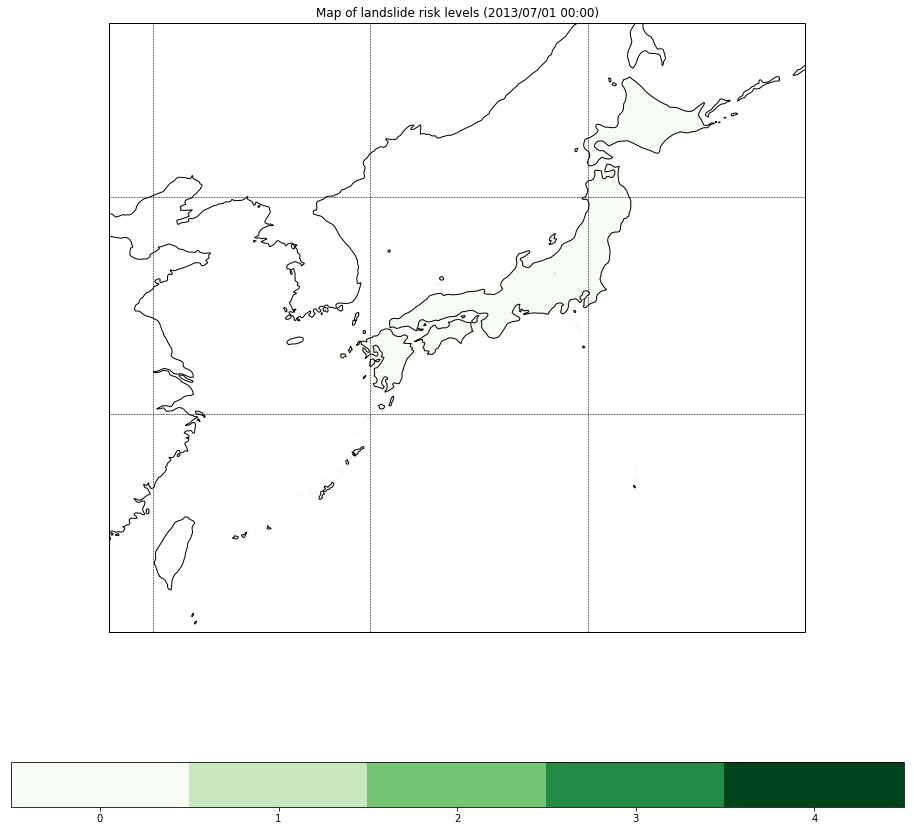

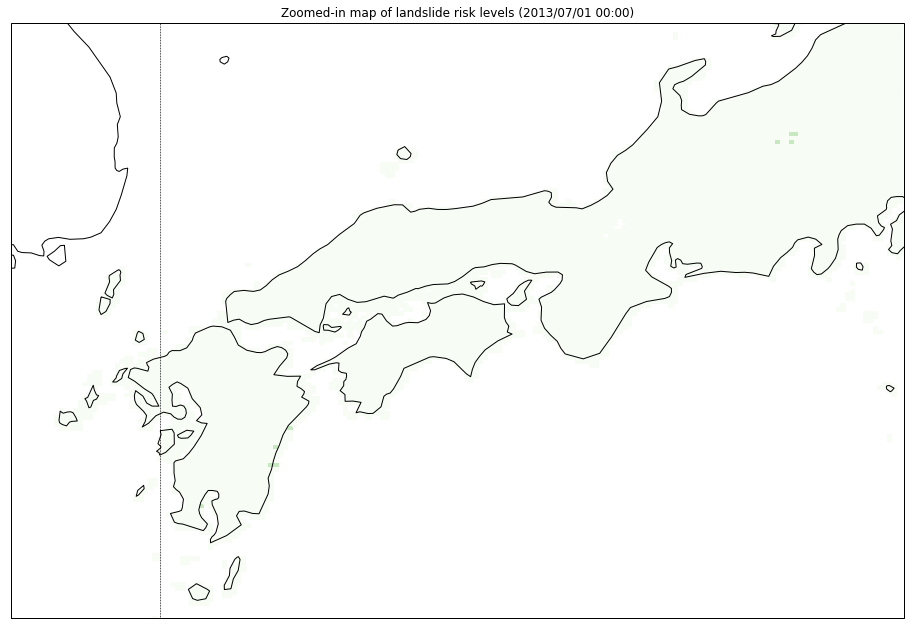

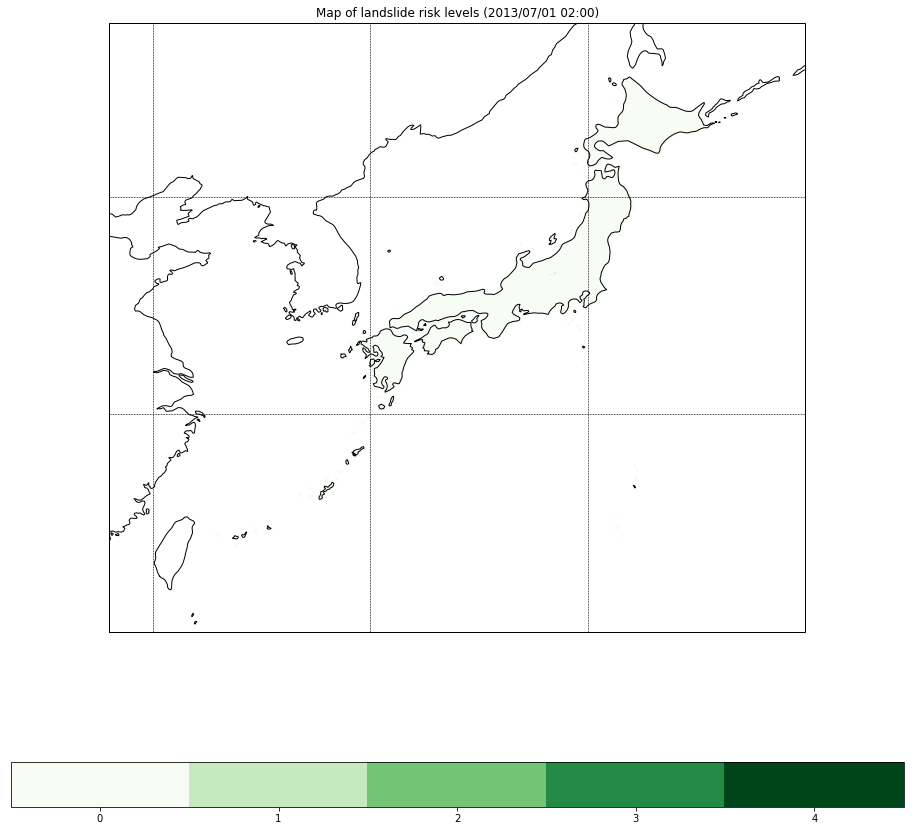

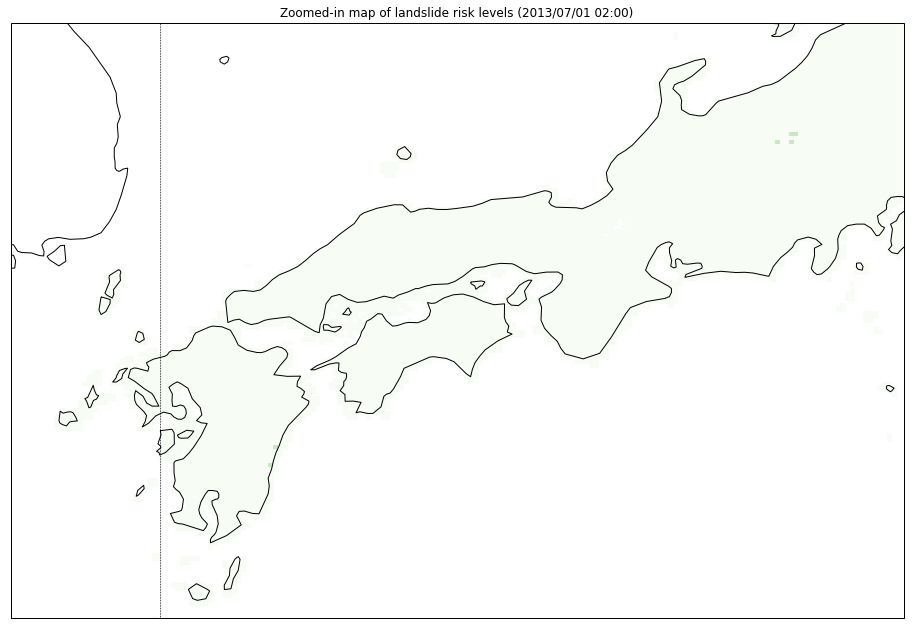

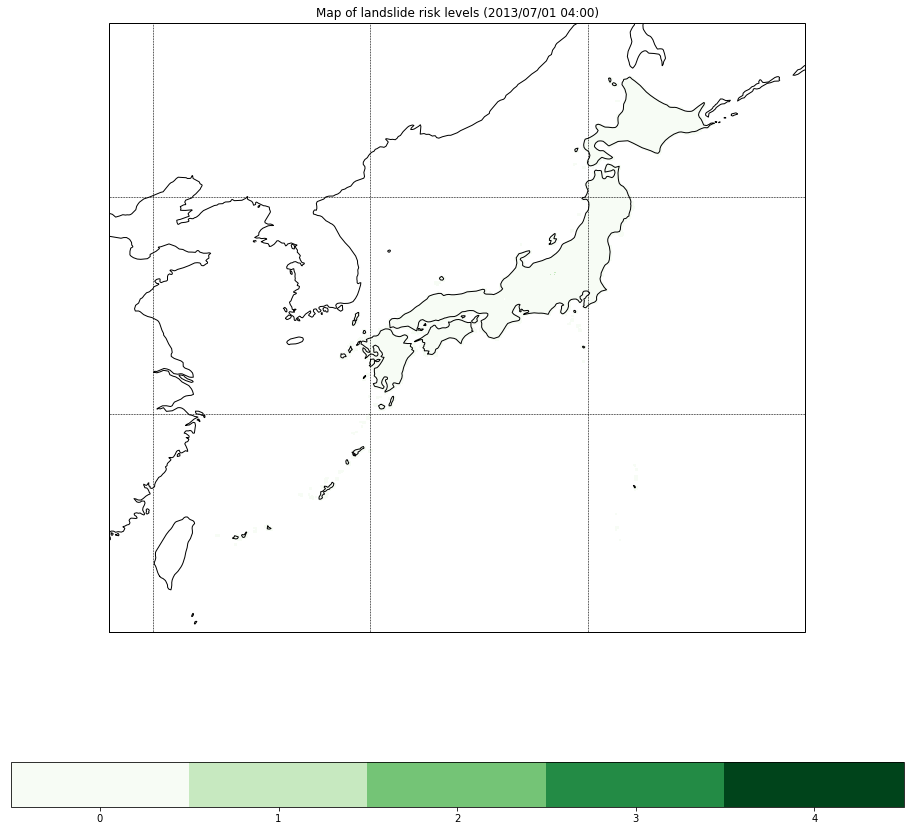

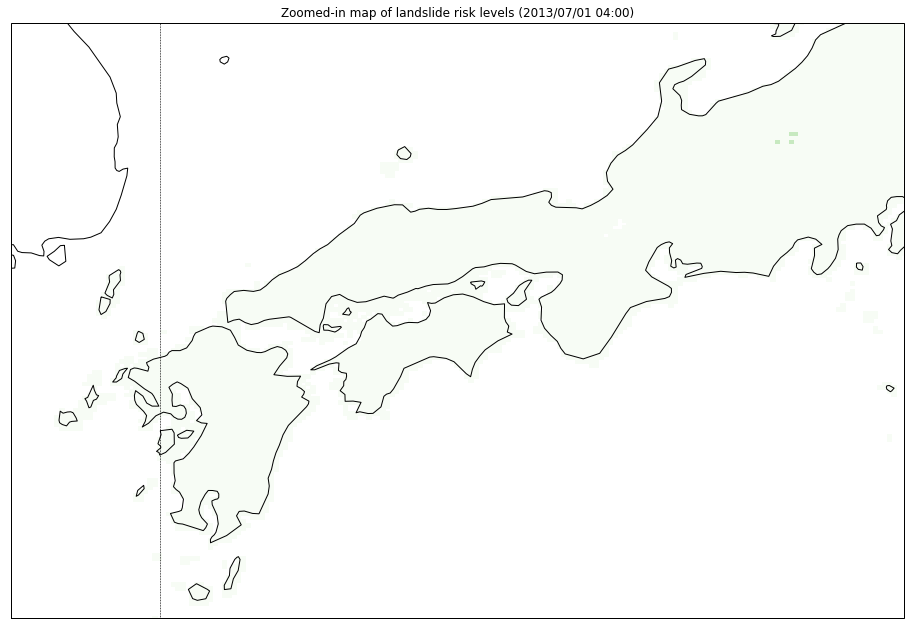

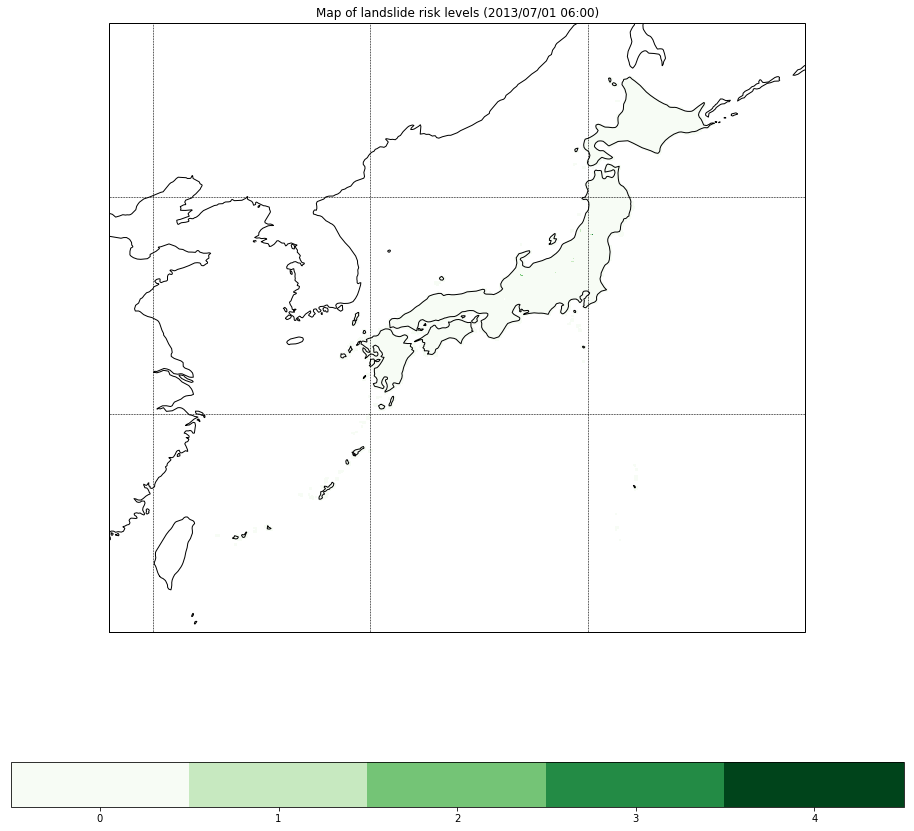

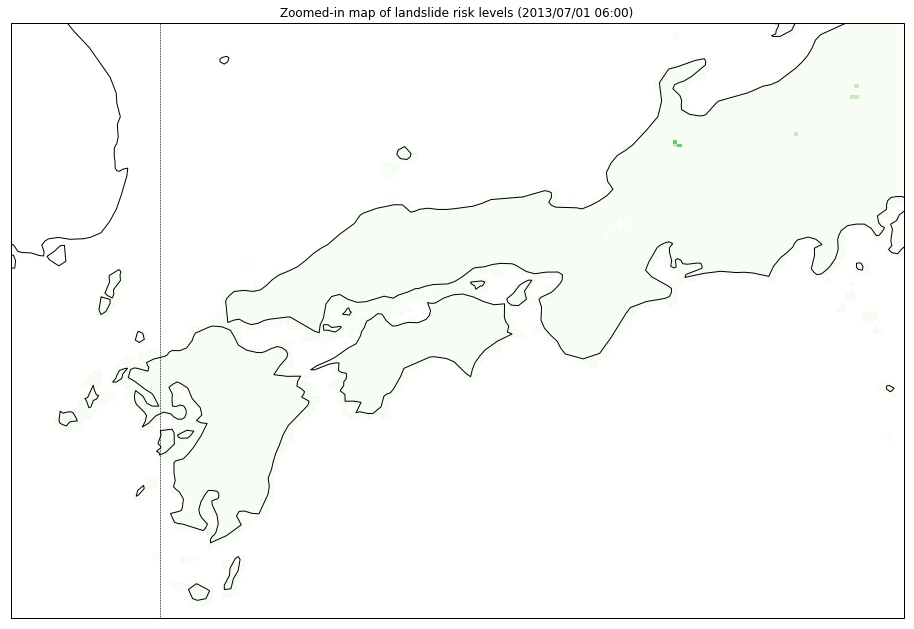

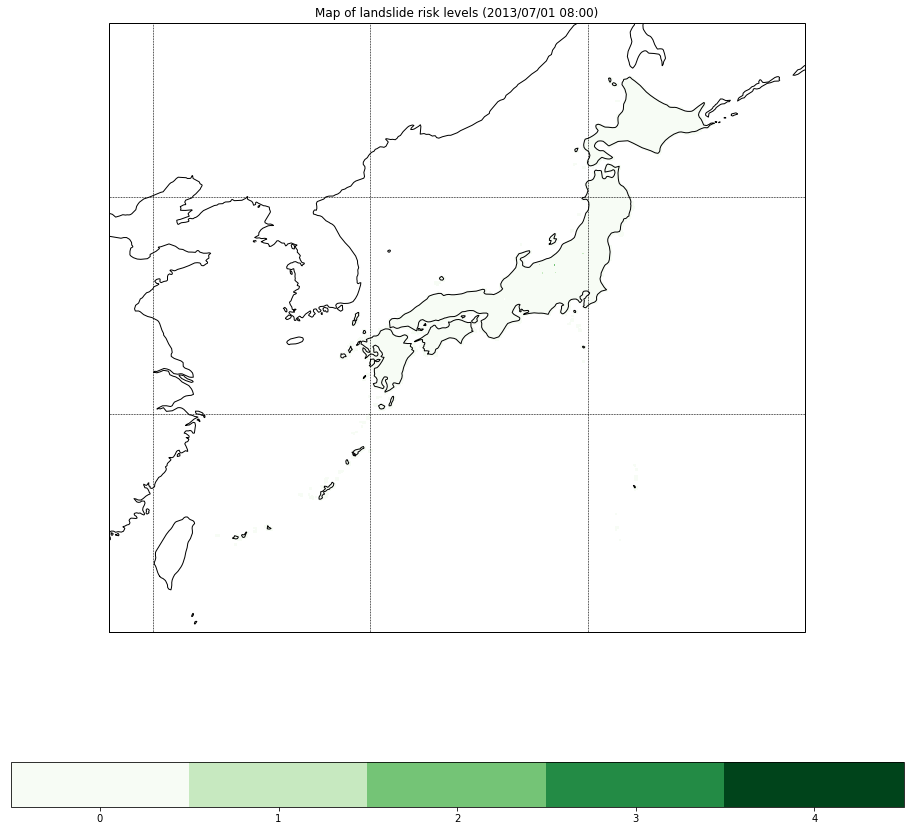

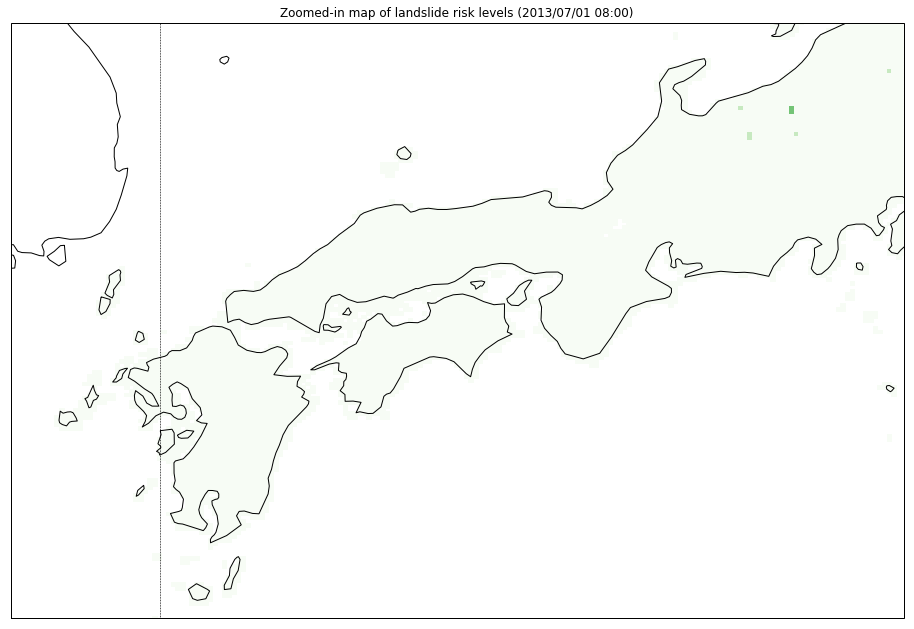

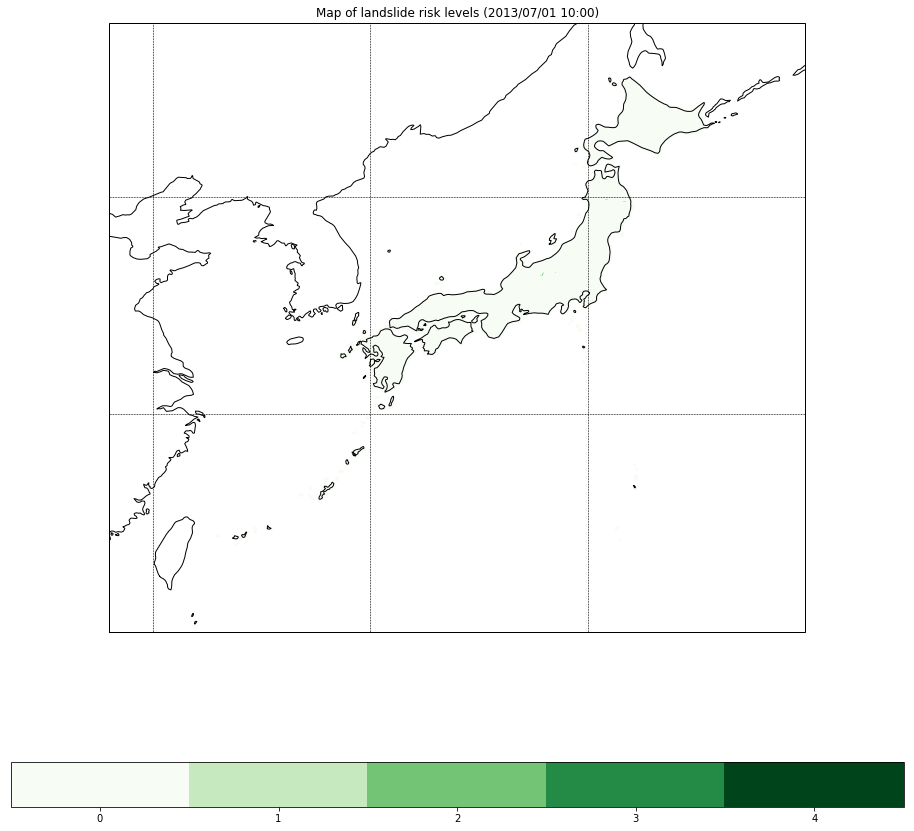

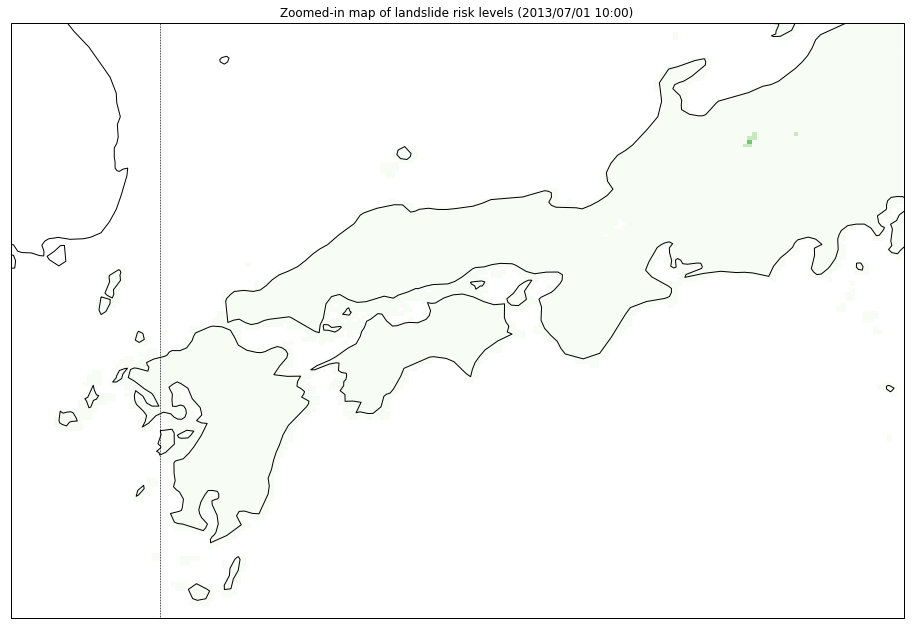

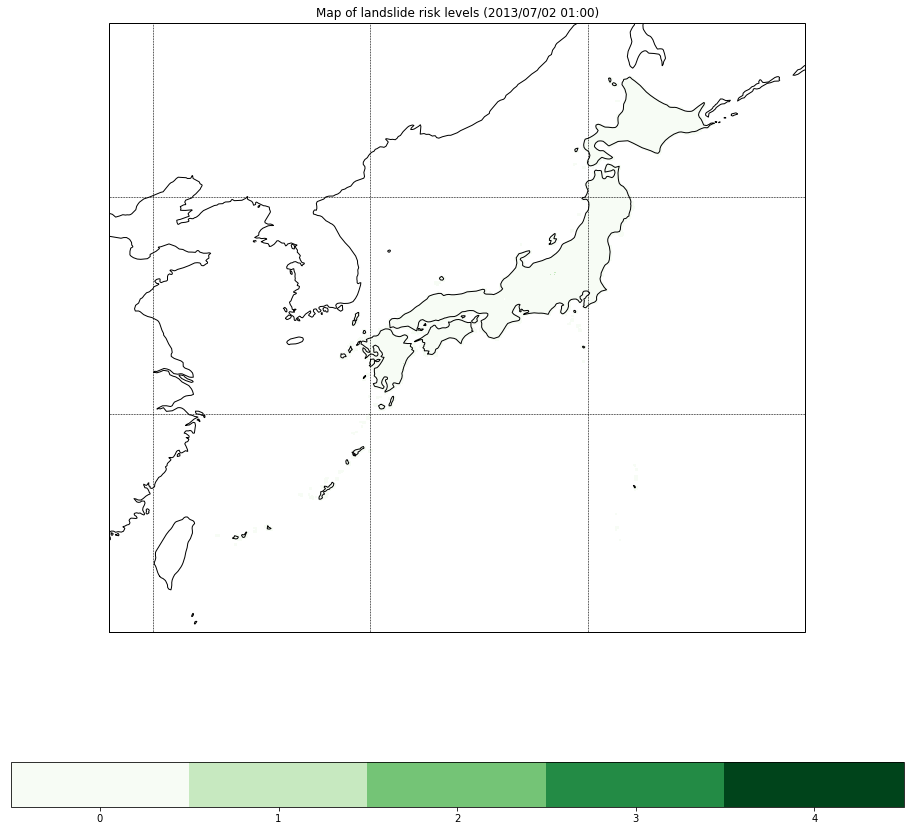

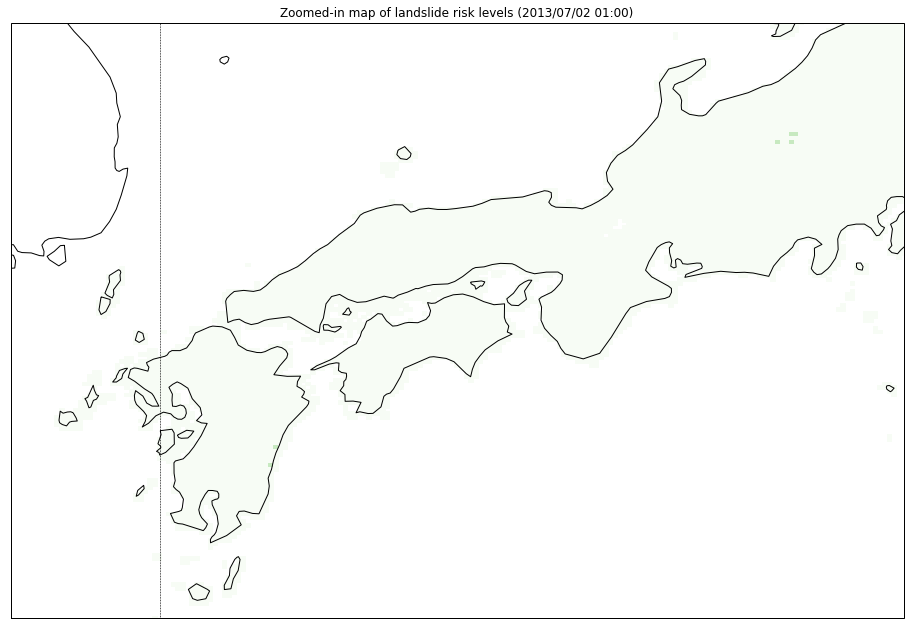

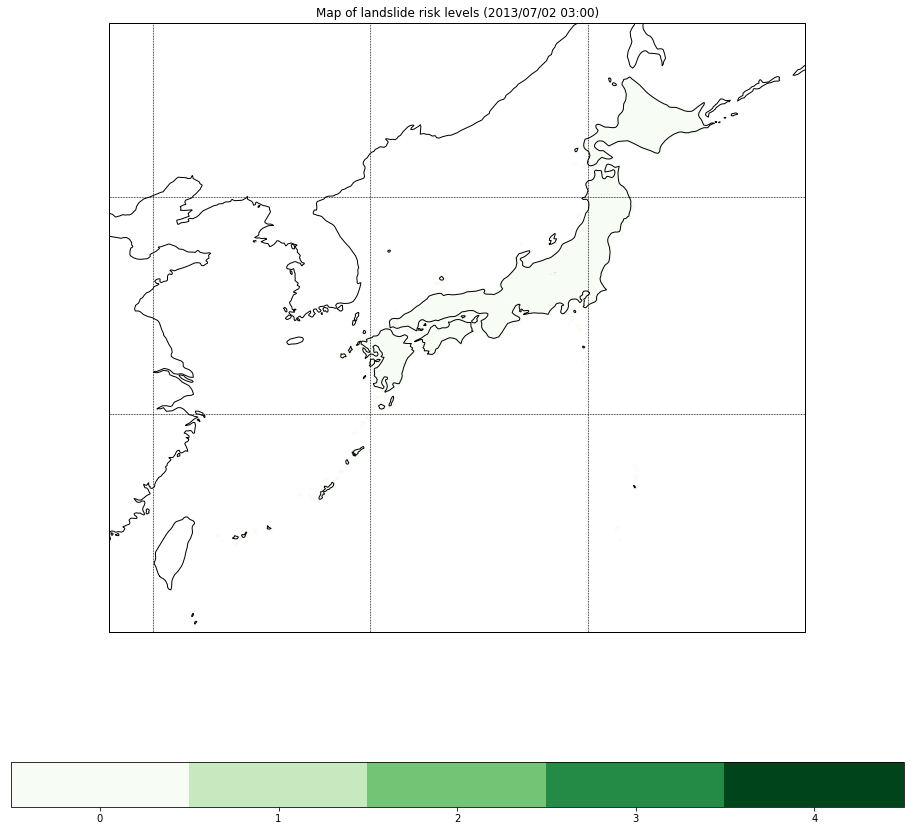

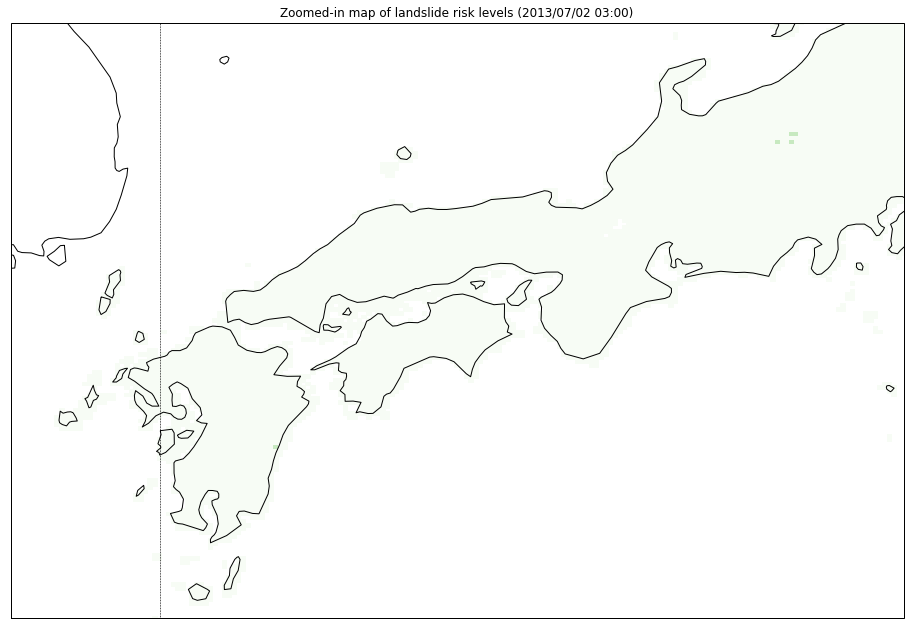

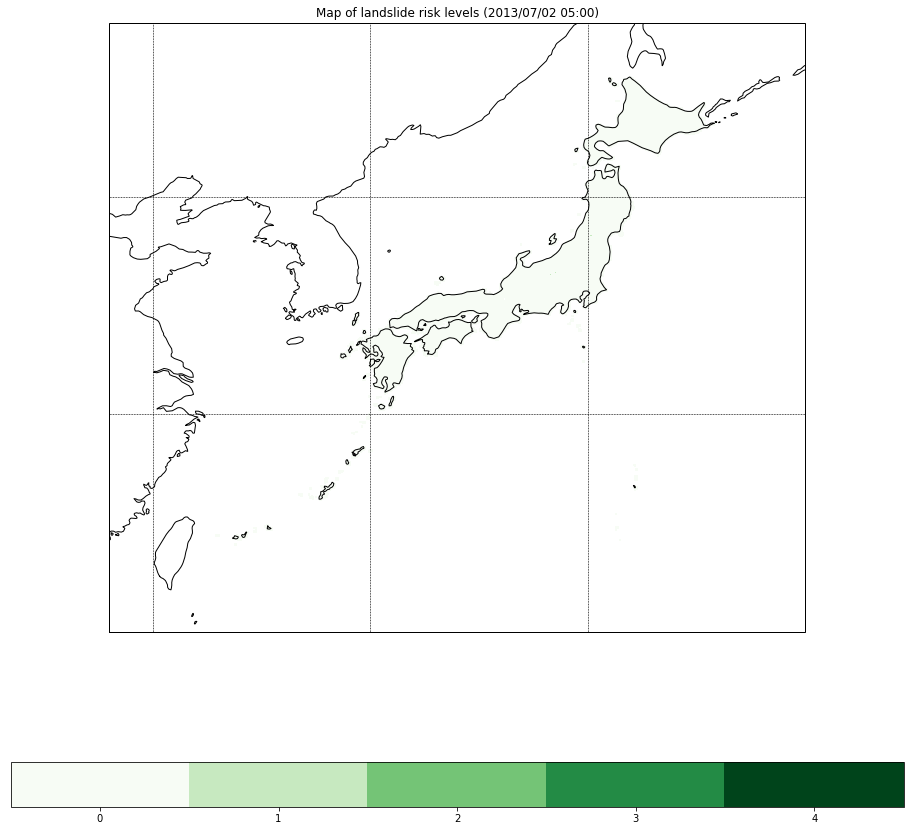

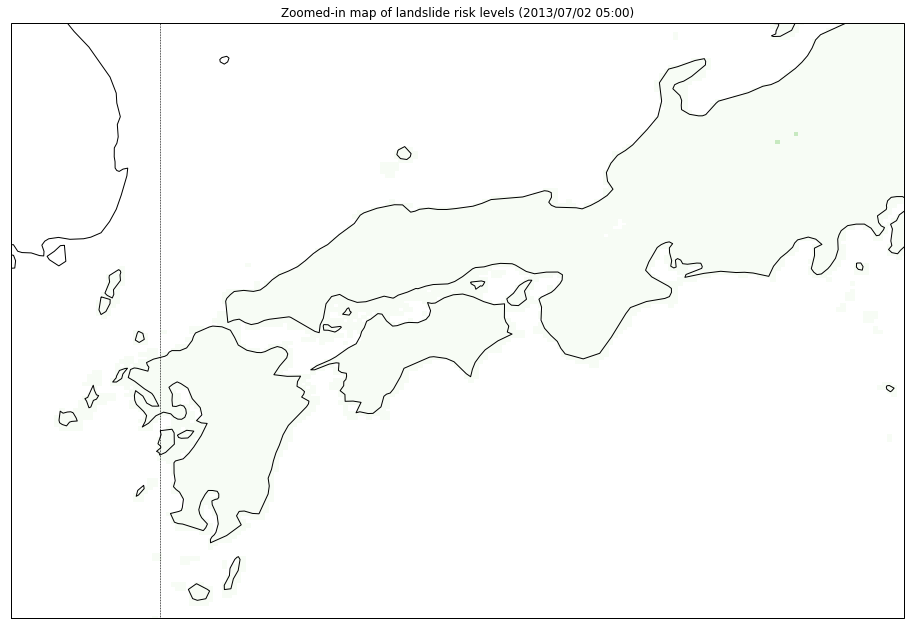

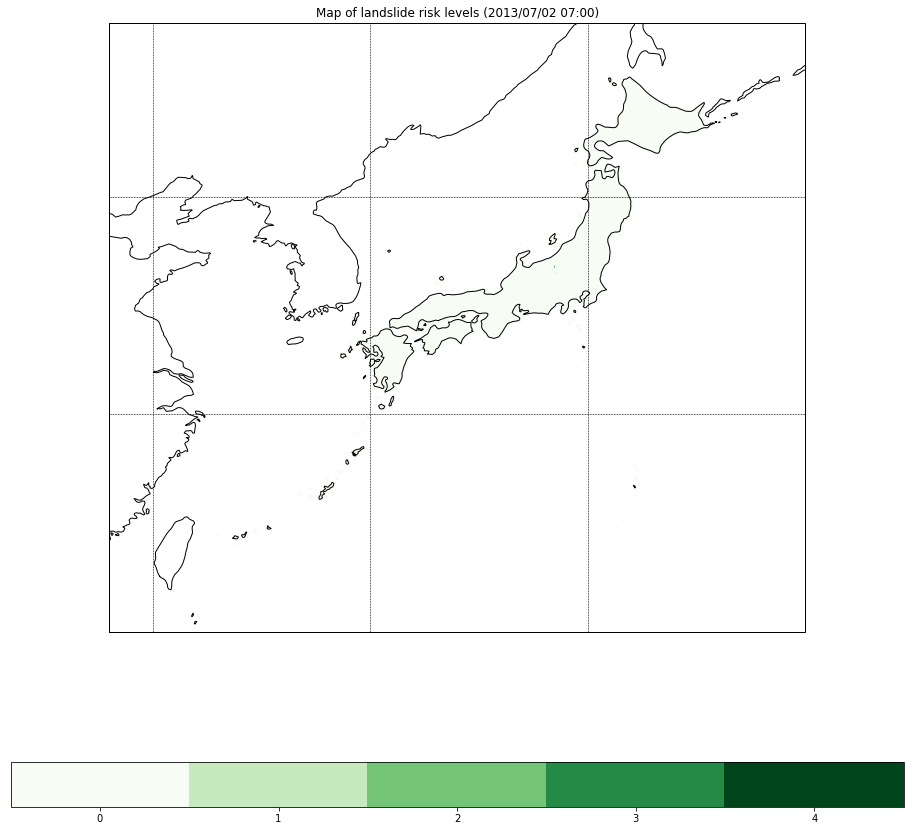

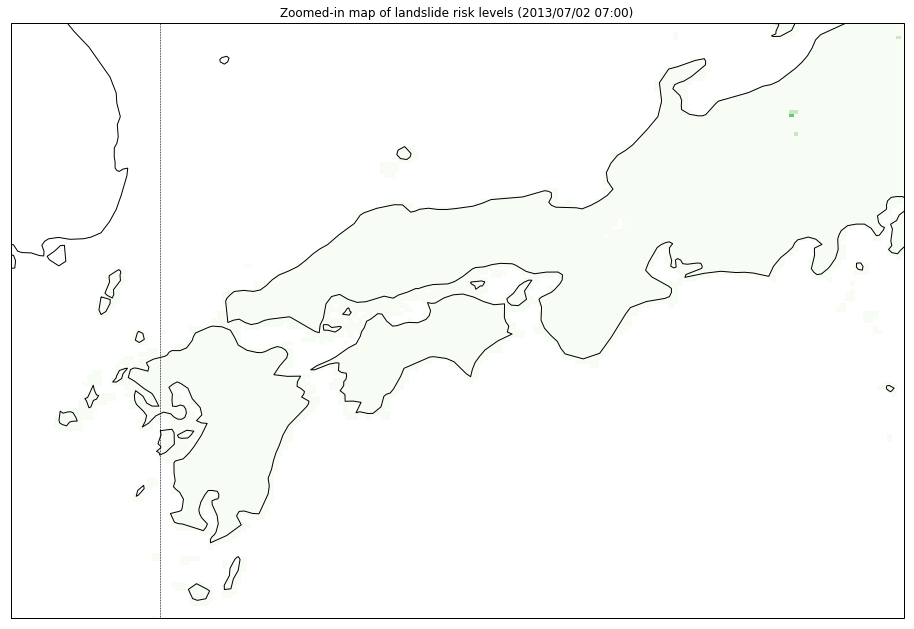

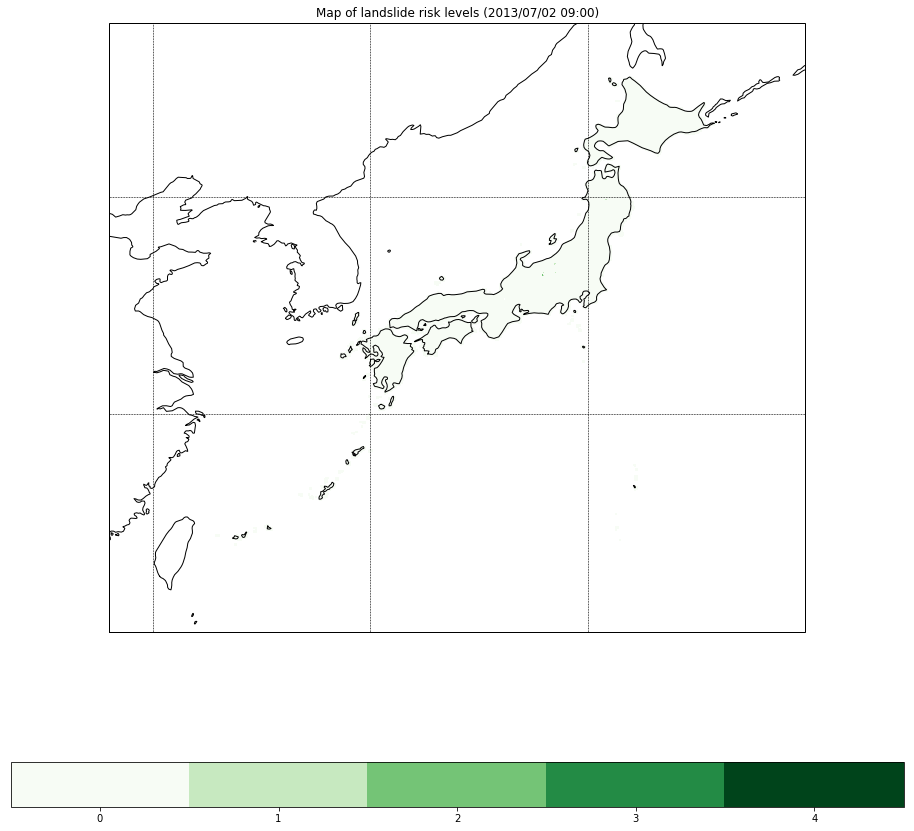

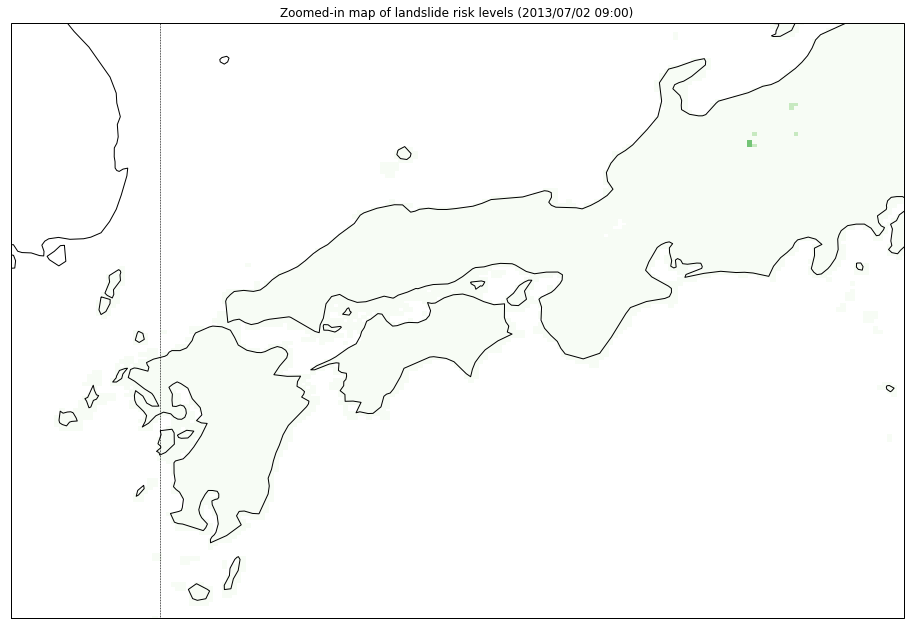

In [11]:
for t in tocheck:
    dt_check = myh5.root.dateTime[t,:]
    dt_check_str = [ str(a, "ascii") for a in dt_check]
    X_check = myh5.root.riskLevels[t,:,:]
    
    # Print a map with date information.
    toplot = np.float16(X_check)
    toplot[toplot == 99] = np.nan # leave irrelevant points unmarked.

    # Plot of nation-wide view.
    fig = plt.figure(figsize=(16,16))
    plt.subplot(1,1,1)
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    north = 48.0
    south = 20.0
    east = 150.0
    west = 118.0
    ax = plt.axes(projection=ccrs.PlateCarree(), zorder=0)
    ax.coastlines("50m", zorder=1)
    ax.set_extent([west, east, south, north], ccrs.PlateCarree())
    
    gl = ax.gridlines(color='k',
                      linestyle=(0, (1, 1)), 
                      xlocs=range(0, 390, 10),
                      ylocs=range(-80, 80, 10)) # draw meridians and parallels
    
    im = ax.pcolormesh(Lon, Lat,
                       np.transpose(toplot),
                       vmin=0,
                       vmax=5,
                       cmap=plt.cm.get_cmap("Greens", 5),
                       transform=ccrs.PlateCarree()) # draw risk levels
    
    mybar = fig.colorbar(im, ax=ax, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], orientation='horizontal')
    mybar.ax.set_xticklabels(['0', '1', '2', "3", "4"])
    
    plt.title("Map of landslide risk levels"+" ("+datetime(dt=dt_check_str)+")")
    
    plt.show()
    
    # Plot of nation-wide view.
    fig = plt.figure(figsize=(16,16))
    plt.subplot(1,1,1)
    ax = fig.add_axes([0.1,0.1,0.8,0.8])
    north = 38.0
    south = 30.0
    east = 140.0
    west = 128.0
    ax = plt.axes(projection=ccrs.PlateCarree(), zorder=0)
    ax.coastlines("50m", zorder=1)
    ax.set_extent([west, east, south, north], ccrs.PlateCarree())
    
    gl = ax.gridlines(color='k',
                      linestyle=(0, (1, 1)), 
                      xlocs=range(0, 390, 10),
                      ylocs=range(-80, 80, 10)) # draw meridians and parallels
    
    im = ax.pcolormesh(Lon, Lat,
                       np.transpose(toplot),
                       vmin=0,
                       vmax=5,
                       cmap=plt.cm.get_cmap("Greens", 5),
                       transform=ccrs.PlateCarree()) # draw risk levels
    
    plt.title("Zoomed-in map of landslide risk levels"+" ("+datetime(dt=dt_check_str)+")")
    
    plt.show()
    

In [11]:
# Close the file connection.
myh5.close()

___